# Step #1: Import Datasets

In [100]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras

In [101]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
bike_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/3yrs_Bike_data.csv')
bike_df

,New_time_format_BIXI,Working_day,week_day,Hours,temp_celcius,dew_pt_celcius,rel_humidity,wind_dir,wind_speed,stn_press,Count,month,Years
0,2017-04-15 00,0,6,0,11.4,-5.4,30,27,8,101.76,144,4,2017
1,2017-04-15 01,0,6,1,10.8,-6.2,30,27,9,101.70,76,4,2017
2,2017-04-15 02,0,6,2,10.9,-6.3,29,27,11,101.65,39,4,2017
3,2017-04-15 03,0,6,3,10.2,-6.0,31,27,9,101.61,40,4,2017
4,2017-04-15 04,0,6,4,8.4,-4.3,40,20,4,101.58,12,4,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14949,2019-10-31 19,1,4,19,12.3,11.9,97,1,12,98.66,166,10,2019
14950,2019-10-31 20,1,4,20,10.3,9.8,97,1,13,98.60,133,10,2019
14951,2019-10-31 21,1,4,21,9.2,8.7,97,3,15,98.60,119,10,2019
14952,2019-10-31 22,1,4,22,8.5,7.9,96,2,11,98.47,121,10,2019


In [103]:
bike_df.describe()

,Working_day,week_day,Hours,temp_celcius,dew_pt_celcius,rel_humidity,wind_dir,wind_speed,stn_press,Count,month,Years
count,14954.000000,14954.000000,14954.000000,14954.000000,14954.000000,14954.000000,14954.000000,14954.000000,14954.000000,14954.000000,14954.000000,14954.000000
mean,0.714391,3.990772,11.503879,16.067875,8.966464,65.646783,18.775512,6.182493,100.626652,1022.998729,7.343253,2017.964892
std,0.451719,2.002919,6.926563,7.405918,7.383633,18.602370,10.299778,2.907672,0.724800,893.835045,2.032786,0.804030
min,0.000000,1.000000,0.000000,-10.700000,-19.300000,14.000000,0.000000,1.000000,96.820000,3.000000,4.000000,2017.000000
25%,0.000000,2.000000,5.000000,10.900000,4.200000,52.000000,13.000000,4.000000,100.160000,262.000000,6.000000,2017.000000
50%,1.000000,4.000000,12.000000,16.800000,9.600000,66.000000,20.000000,6.000000,100.600000,833.500000,7.000000,2018.000000
75%,1.000000,6.000000,18.000000,21.700000,14.600000,81.000000,26.000000,8.000000,101.080000,1527.000000,9.000000,2019.000000
max,1.000000,7.000000,23.000000,35.800000,24.300000,100.000000,36.000000,25.000000,102.830000,4921.000000,11.000000,2019.000000


In [104]:
bike_series = pd.DataFrame(bike_df['Count'])
bike_series

,Count
0,144
1,76
2,39
3,40
4,12
...,...
14949,166
14950,133
14951,119
14952,121


# Step #2: Visualize Dataset

In [105]:
import csv


# DO NOT CHANGE THIS CODE
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [106]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


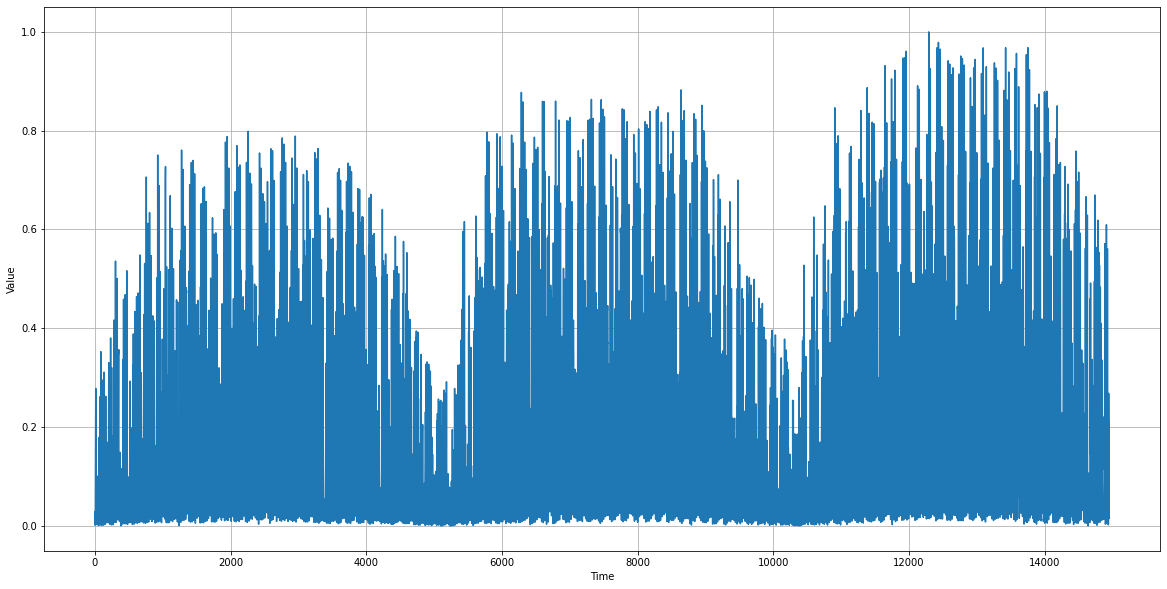

In [107]:
time_step = []
counts = []

with open('/content/drive/MyDrive/Colab Notebooks/Datasets/3yrs_Bike_data.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step = 0
  for row in reader:
    counts.append(float(row[-3]))
    time_step.append(step)
    step = step + 1

series = np.array(counts)

min = np.min(series)
max = np.max(series)
series -= min
series /= max
time = np.array(time_step)

plt.figure(figsize=(20, 10))
plot_series(time, series)


In [108]:
plt.savefig('Time_Series_Hourlycounts.png')

<Figure size 432x288 with 0 Axes>

In [109]:
#plt.savefig('Time_Series_Hourly.png')

In [125]:
split_time = 10000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


# DO NOT CHANGE THIS CODE
window_size = 100
batch_size = 100
shuffle_buffer_size = 1000


train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

In [111]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=128, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
100/100 [==============================] - 5s 20ms/step - loss: 0.3186 - mae: 0.6469
Epoch 2/100
100/100 [==============================] - 2s 20ms/step - loss: 0.2534 - mae: 0.5927
Epoch 3/100
100/100 [==============================] - 2s 21ms/step - loss: 0.2350 - mae: 0.5704
Epoch 4/100
100/100 [==============================] - 2s 20ms/step - loss: 0.2188 - mae: 0.5501
Epoch 5/100
100/100 [==============================] - 2s 21ms/step - loss: 0.2009 - mae: 0.5254
Epoch 6/100
100/100 [==============================] - 2s 21ms/step - loss: 0.1840 - mae: 0.4984
Epoch 7/100
100/100 [==============================] - 2s 21ms/step - loss: 0.1665 - mae: 0.4670
Epoch 8/100
100/100 [==============================] - 2s 21ms/step - loss: 0.1496 - mae: 0.4343
Epoch 9/100
100/100 [==============================] - 2s 21ms/step - loss: 0.1334 - mae: 0.4030
Epoch 10/100
100/100 [==============================] - 2s 21ms/step - loss: 0.1190 - mae: 0.3783
Epoch 11/100
100/100 [=======

(1e-08, 0.0001, 0.0, 60.0)

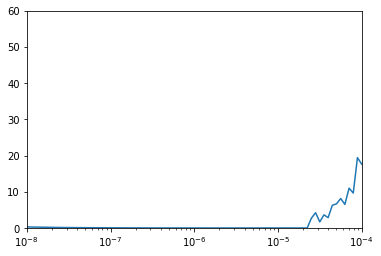

In [112]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [126]:
#train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer = shuffle_buffer_size)

validation_set = windowed_dataset(x_valid, window_size=window_size, batch_size=batch_size, shuffle_buffer = shuffle_buffer_size)


model = tf.keras.models.Sequential([
   tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])



In [127]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), metrics=["mae"])
history = model.fit(train_set,epochs=100, validation_data=validation_set)

Epoch 1/100
99/99 [==============================] - 7s 46ms/step - loss: 0.5697 - mae: 0.5326 - val_loss: 0.0481 - val_mae: 0.1717
Epoch 2/100
99/99 [==============================] - 4s 41ms/step - loss: 0.0232 - mae: 0.1194 - val_loss: 0.0396 - val_mae: 0.1533
Epoch 3/100
99/99 [==============================] - 4s 39ms/step - loss: 0.0202 - mae: 0.1093 - val_loss: 0.0351 - val_mae: 0.1425
Epoch 4/100
99/99 [==============================] - 4s 39ms/step - loss: 0.0184 - mae: 0.1032 - val_loss: 0.0324 - val_mae: 0.1358
Epoch 5/100
99/99 [==============================] - 4s 38ms/step - loss: 0.0172 - mae: 0.0993 - val_loss: 0.0311 - val_mae: 0.1331
Epoch 6/100
99/99 [==============================] - 4s 38ms/step - loss: 0.0166 - mae: 0.0975 - val_loss: 0.0299 - val_mae: 0.1297
Epoch 7/100
99/99 [==============================] - 4s 38ms/step - loss: 0.0161 - mae: 0.0957 - val_loss: 0.0292 - val_mae: 0.1276
Epoch 8/100
99/99 [==============================] - 4s 38ms/step - loss: 0.

In [128]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [129]:
series = np.asarray(series).astype(np.float32)


rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)

rnn_forecast = rnn_forecast[split_time - window_size: -1, -1, 0]

rnn_forecast.shape

(4954,)

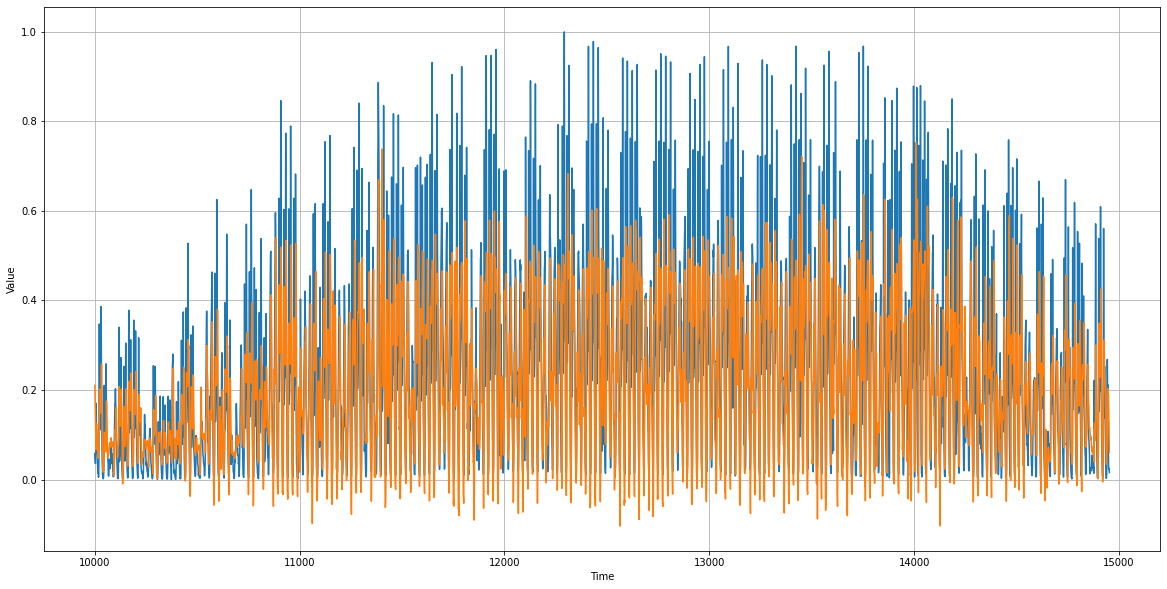

In [130]:
plt.figure(figsize=(20, 10))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [131]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.099616654

In [132]:
model.save('Timeseries_bikerental.h5')